C:\Users\shiva\AppData\Local\Temp\ipykernel_2536\2670510555.py:8: RuntimeWarning: divide by zero encountered in divide
  return (green_band - nir_band) / (green_band + nir_band)
C:\Users\shiva\AppData\Local\Temp\ipykernel_2536\2670510555.py:8: RuntimeWarning: invalid value encountered in divide
  return (green_band - nir_band) / (green_band + nir_band)


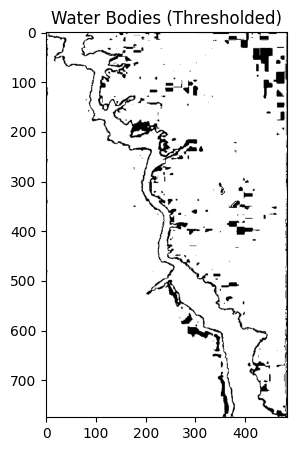

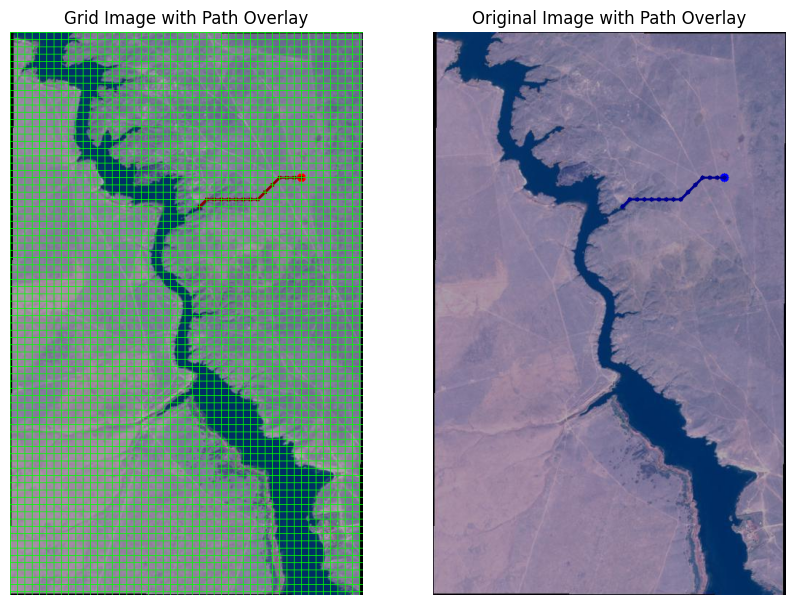

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush

def calculate_ndwi(green_band, nir_band):
    """Calculate NDWI using green and NIR bands."""
    return (green_band - nir_band) / (green_band + nir_band)

def process_image(image_path):
    """Process a single image to calculate NDWI and generate water mask."""
    # Read the image (assuming it's a JPG)
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the Green (B03) and NIR (B08) bands. 
    green_band = image[:, :, 1]  # Green channel (G)
    nir_band = image[:, :, 0]     # Simulated NIR using Red channel (R)

    # Calculate NDWI
    ndwi = calculate_ndwi(green_band, nir_band)

    # Apply threshold to classify water
    water_mask = ndwi > 0.3  # Adjust threshold as necessary

    return ndwi, water_mask

def visualize_water_bodies(ndwi, water_mask, output_path):
    """Visualize the NDWI and water mask, and save the water bodies threshold image."""
    plt.figure(figsize=(10, 5))
    
    # plt.subplot(1, 2, 1)
    # plt.title('NDWI Image')
    # plt.imshow(ndwi, cmap='Blues')
    # plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.title('Water Bodies (Thresholded)')
    plt.imshow(water_mask, cmap='gray')
    plt.savefig(output_path)  # Save the threshold image
    plt.show()

def preprocess_image(image):
    """Apply Gaussian blur to smooth edges and enhance water regions."""
    blurred = cv2.GaussianBlur(image, (5, 5), 0)  # Smoothing
    return blurred

def create_grid_map(image, output_path, grid_size=5):
    """Divide image into small grids, color-code water vs. non-water regions, and add grid lines and limited axis labels."""
    # Get image dimensions
    height, width, _ = image.shape
    
    # Create an empty grid image
    grid_image = np.zeros_like(image)
    
    # Define flexible thresholds for blue detection
    blue_lower = np.array([0, 0, 180])  # Lower threshold for blue
    blue_upper = np.array([70, 70, 255])  # Upper threshold for blue

    # Apply color thresholding
    mask = cv2.inRange(image, blue_lower, blue_upper)

    # Refine the mask with morphological operations
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Closing to fill gaps
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)  # Dilation to expand areas

    # Iterate over the image with `grid_size` and mark water areas
    for y in range(0, height, grid_size):
        for x in range(0, width, grid_size):
            # Extract the current grid cell from the mask
            cell_mask = mask[y:y+grid_size, x:x+grid_size]
            
            # Check if a significant portion of the cell is detected as water
            if np.mean(cell_mask) > 128:  # Majority water pixels in the cell
                grid_image[y:y+grid_size, x:x+grid_size] = [0, 0, 255]  # Blue for water
            else:
                grid_image[y:y+grid_size, x:y+grid_size] = [128, 128, 128]  # Gray for non-water

    # Save the grid image
    cv2.imwrite(output_path, cv2.cvtColor(grid_image, cv2.COLOR_RGB2BGR))

    return grid_image

def mark_point_and_show_grid_with_dijkstra_path(image_path, start_point=(400, 300), grid_size=10):
    """Display image with grid markings, mark the start point, and visualize the shortest paths to all river pixels using Dijkstra's algorithm."""
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying in matplotlib
    original_image = image.copy()  # Copy of the original image for marking

    # Convert image to HSV to detect blue regions (river)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 150, 0])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv_image, lower_blue, upper_blue)  # Create mask for blue regions (river pixels)

    # Mark the start point
    sx, sy = start_point
    cv2.circle(image_rgb, (sx, sy), 6, (255, 0, 0), -1)  # Mark start point in red on image with grid
    cv2.circle(original_image, (sx, sy), 6, (255, 0, 0), -1)  # Mark start point in red on original image

    # Dijkstra's Setup
    height, width = mask.shape
    visited = set()
    distances = {start_point: 0}
    priority_queue = []
    heappush(priority_queue, (0, sx, sy, []))  # (distance, x, y, path)

    # Directions: up, down, left, right, and diagonals
    directions = [
        (-1, 0), (1, 0), (0, -1), (0, 1),  # Up, down, left, right
        (-1, -1), (-1, 1), (1, -1), (1, 1)  # Diagonals
    ]

    # Store paths to all river pixels
    river_paths = []
    
    # Dijkstra's search
    while priority_queue:
        current_distance, cx, cy, path = heappop(priority_queue)
        
        if (cx, cy) in visited:
            continue
        visited.add((cx, cy))

        # If we reached a blue pixel (river), save the path
        if mask[cy, cx] == 255:  # Found a blue pixel (river)
            river_paths.append(path + [(cx, cy)])  # Store the path to the river
            continue  # Continue searching for other rivers

        # Explore neighbors
        for dx, dy in directions:
            nx, ny = cx + dx * grid_size, cy + dy * grid_size
            if 0 <= nx < width and 0 <= ny < height and (nx, ny) not in visited:
                new_distance = current_distance + (np.sqrt(2) if (dx != 0 and dy != 0) else 1)  # Cost for diagonal movement
                
                if (nx, ny) not in distances or new_distance < distances[(nx, ny)]:
                    distances[(nx, ny)] = new_distance
                    heappush(priority_queue, (new_distance, nx, ny, path + [(cx, cy)]))

    # Draw the shortest path to the first found river
    if river_paths:
        shortest_path = river_paths[0]  # Get the first river path
        for (px, py) in shortest_path:
            cv2.circle(image_rgb, (px, py), 3, (139, 0, 0), -1)  # Dark red circles for path on grid image
            cv2.circle(original_image, (px, py), 3, (139, 0, 0), -1)  # Dark red circles for path on original image
            
            # Connect points with lines for better visualization
            if shortest_path.index((px, py)) > 0:
                prev_px, prev_py = shortest_path[shortest_path.index((px, py)) - 1]
                cv2.line(image_rgb, (prev_px, prev_py), (px, py), (139, 0, 0), 2)  # Dark red line on grid image
                cv2.line(original_image, (prev_px, prev_py), (px, py), (139, 0, 0), 2)  # Dark red line on original image

    for i in range(0, width, grid_size):
        cv2.line(image_rgb, (i, 0), (i, height), (0, 255, 0), 1)  # Vertical grid lines in green
    for j in range(0, height, grid_size):
        cv2.line(image_rgb, (0, j), (width, j), (0, 255, 0), 1)  # Horizontal grid lines in green


    # Display both images
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Grid Image with Path Overlay")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Path Overlay")
    plt.axis('off')

    plt.show()

# Main function to execute the entire process
def main():
    # Path to your input image
    image_path = 'Water Bodies Dataset/Images/water_body_855.jpg'  # Replace with your JPG image path
    
    # Process the image and calculate NDWI
    ndwi, water_mask = process_image(image_path)

    # Visualize NDWI and water bodies
    visualize_water_bodies(ndwi, water_mask, output_path='water_bodies_threshold.jpg')

    # Create a grid map
    grid_image = create_grid_map(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), output_path='grid_water_map.jpg', grid_size=5)

    # Start point for pathfinding (can be adjusted)
    start_point = (400, 200)  # Replace with your desired starting coordinates
    
    # Mark points and show the grid with Dijkstra's paths
    mark_point_and_show_grid_with_dijkstra_path(image_path, start_point=start_point)

if __name__ == "__main__":
    main()
